In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import json
import os

# Read data

Прочитаем данные, собранные с виртуальной машины и конвертированные из .json в .csv формат для анализа.

In [3]:
input_dir = 'data/data_run02/csv/'
loads_json = 'data/data_run02/2018-09-27T16:32:52-loads.json'
fails_json = 'data/data_run02/2018-09-27T16:32:52-fails.json'

In [4]:
files_list = os.listdir(input_dir)
data = {}

for afile in files_list:
    
    afile_path = os.path.join(input_dir, afile)

    if not os.path.isfile(afile_path):
        continue
        
    data[afile[:-4]] = pd.read_csv(afile_path).fillna("None").sort_values(by=['timestamp'])
    

# конвертируем время в секунды и отнимем начало сбора данных для удобства дальнейшей работы
start_time = -999
for key in data.keys():
    start_time_key = data[key]['timestamp'].min()
    if start_time == -999:
        start_time = start_time_key
    if start_time_key < start_time:
        start_time = start_time_key

for key in data.keys():
    data[key]['timestamp'] -= start_time
    data[key]['timestamp'] /= 10.**9

В результате имеем данные в следующем формате:

    data = {'Companent Name': pandas.DataFrame(), ...},

где **pandas.DataFrame()** - таблица со значениями параметров компонента. Например, имена всех доступных компонент СХД:

In [5]:
list(data.keys())

['100000000000',
 '100000000100',
 '100000000200',
 '100000000300',
 '100000000400',
 'fc',
 'scsi-35000cca03e900860',
 'scsi-35000cca03e925b94',
 'scsi-35000cca03e938d00',
 'scsi-35000cca03e94a4f0',
 'scsi-35000cca03e94a5d0',
 'scsi-35000cca03e94a5d8',
 'scsi-35000cca03e94ae60',
 'scsi-35000cca03e94af5c',
 'scsi-35000cca03e959ef4',
 'scsi-35000cca03e95bb54',
 'scsi-35000cca03e96692c',
 'scsi-35000cca03e966940',
 'scsi-35000cca03e966aec',
 'scsi-35000cca03e966c48',
 'scsi-35000cca03e96c6e0',
 'scsi-35000cca03e973164',
 'scsi-35000cca03e973350',
 'scsi-35000cca03e975c28',
 'scsi-35000cca03e975c30',
 'scsi-35000cca03e975ff4',
 'scsi-35000cca03e977678',
 'scsi-35000cca03e9776e0',
 'scsi-35000cca03e9776fc',
 'scsi-35000cca03e977730',
 'scsi-35000cca03e978228',
 'scsi-35000cca03e981a20',
 'scsi-35000cca03e982594',
 'scsi-35000cca03e983a18',
 'scsi-35000cca03e983abc',
 'scsi-35000cca03e983d24',
 'scsi-35000cca03e985284',
 'scsi-35000cca03e9852b8',
 'scsi-35000cca03e98551c',
 'scsi-35000cca03

Значения параметров для контроллера **sp-235-199** и других компонентов:

In [6]:
data['sp-235-199'].head(10) # вывод первых 10 строк таблицы

timestamp        type        name health_state       traffic   load
772     0.000000  controller  sp-235-199           OK  6.389618e-07   9.16
4671    0.217341  controller  sp-235-199           OK  1.411438e-06  27.83
2116   28.746987  controller  sp-235-199           OK  0.000000e+00  12.50
5128   30.925177  controller  sp-235-199           OK  0.000000e+00  14.24
3137   54.247973  controller  sp-235-199           OK  5.892448e-03  10.72
4838   58.051123  controller  sp-235-199           OK  6.351767e-03  34.77
2744   80.546957  controller  sp-235-199           OK  5.858583e-03   8.87
5361  100.043547  controller  sp-235-199           OK  5.817776e-03  14.19
1437  107.845815  controller  sp-235-199           OK  6.386366e-03  13.00
1854  143.862065  controller  sp-235-199           OK  0.000000e+00   8.59

In [7]:
data['storage_state'].head(10) # вывод первых 10 строк таблицы

timestamp  read_ops  write_ops  read_await_ms  write_await_ms  async  \
772     0.000000       0.2        0.0           0.00            0.00      1   
4671    0.217341       0.2        0.0           0.00            0.00      1   
2116   28.746987       0.2        0.0           0.00            0.00      1   
5128   30.925177       0.2        0.0           0.00            0.00      1   
3137   54.247973      63.8       67.0         185.13          409.52      1   
4838   58.051123      65.0       68.8          83.73          867.80      1   
2744   80.546957     105.6       93.6         159.58          500.80      1   
5361  100.043547       0.0        0.0           0.00            0.00      0   
1437  107.845815     103.6       91.6         190.09          493.56      1   
1854  143.862065       6.0        4.2          64.67          391.43      1   

       crrq  avg_qsz  svctm_ms    kB_read      ...        io_write_4  \
772     0.2     0.00      0.00  209144812      ...             17202   
4671    0.2     0.00      0.00  209144812      ...             17202   
2116    0.2     0.00      0.00  209144824      ...             17202   
5128    0.2     0.00      0.00  209144824      ...             17202   
3137   63.8    20.83     20.12  209144836      ...             17202   
4838   65.0    31.68     29.95  209252872      ...             17202   
2744  105.6    31.75     20.09  209287564      ...             17202   
5361    0.0     0.00      0.00          0      ...              -999   
1437  103.6    32.31     20.52  209512472      ...             17202   
1854    6.0     1.55     12.75  209682276      ...             17202   

      io_write_8  io_write_16  io_write_32  io_write_64  io_write_128  \
772        31720         1775         5394        46874         50470   
4671       31720         1775         5394        46874         50470   
2116       31720         1775         5394        46874         50470   
5128       31720         1775         5394        46874         50470   
3137       31720         1775         5394        46874         50470   
4838       31720         1775         5394        48616         50470   
2744       31720         1775         5394        49159         50470   
5361        -999         -999         -999         -999          -999   
1437       31720         1775         5394        52626         50470   
1854       31720         1775         5394        55217         50470   

      io_write_256  io_write_512  io_write_1024  io_write_2048  
772          51544         13890          28389          29299  
4671         51544         13890          28389          29299  
2116         51544         13890          28389          29299  
5128         51544         13890          28389          29299  
3137         51544         13890          28389          29299  
4838         51544         13890          28389          29299  
2744         51544         13890          28389          29299  
5361          -999          -999           -999           -999  
1437         51544         13890          28389          29299  
1854         51544         13890          28389          29299  

[10 rows x 31 columns]

In [8]:
data['scsi-35000cca03e9852b8'].head(10) # вывод первых 10 строк таблицы

timestamp        type                    name health_state  \
772     0.000000  disk_drive  scsi-35000cca03e9852b8           OK   
4670    0.217341  disk_drive  scsi-35000cca03e9852b8           OK   
2116   28.746987  disk_drive  scsi-35000cca03e9852b8           OK   
5126   30.925177  disk_drive  scsi-35000cca03e9852b8           OK   
3137   54.247973  disk_drive  scsi-35000cca03e9852b8           OK   
4836   58.051123  disk_drive  scsi-35000cca03e9852b8           OK   
2744   80.546957  disk_drive  scsi-35000cca03e9852b8           OK   
5358  100.043547  disk_drive  scsi-35000cca03e9852b8           OK   
1437  107.845815  disk_drive  scsi-35000cca03e9852b8           OK   
1854  143.862065  disk_drive  scsi-35000cca03e9852b8           OK   

      capacity_gb type.1  
772          2794    HDD  
4670         2794    HDD  
2116         2794    HDD  
5126         2794    HDD  
3137         2794    HDD  
4836         2794    HDD  
2744         2794    HDD  
5358         2794    HDD  
1437         2794    HDD  
1854         2794    HDD

In [9]:
data['volume_679e1559-e395-4bcd-9f70-491c126acbcd_pty-vol-d236ddef-c1b0-11e8-8448-42054c31268b'].head(10) # вывод первых 10 строк таблицы

timestamp    type                                               name  \
769     0.000000  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
4649    0.217341  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
2105   28.746987  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
5102   30.925177  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
3121   54.247973  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
4814   58.051123  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
2730   80.546957  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
1431  107.845815  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
1846  143.862065  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   
5228  152.063596  volume  volume_679e1559-e395-4bcd-9f70-491c126acbcd_pt...   

     health_state     read_kbps  write_kbps  pci  
769          None  7.629395e-07    0.000000   16  
4649         None  7.629395e-07    0.000000   16  
2105         None  7.629395e-07    0.000000   16  
5102         None  7.629395e-07    0.000000   16  
3121         None  3.894043e-03    0.004089   16  
4814         None  3.955841e-03    0.004199   16  
2730         None  6.433868e-03    0.005713   16  
1431         None  6.311798e-03    0.005591   16  
1846         None  3.662109e-04    0.000256   16  
5228         None  0.000000e+00    0.000000   16

# Data generation information

In [10]:
import jsonlines

def read_jsonl(file_path):

    lines = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            lines.append(obj)

    columns = lines[0].keys()
    data = []
    for aline in lines:
        data_line = []
        for acol in columns:
            data_line.append(aline[acol])
        data.append(data_line)

    data = pd.DataFrame(data=data, columns=columns)
    return data

In [11]:
data_loads = read_jsonl(loads_json)
print('Generated loads:')
print('Shape: ', data_loads.shape)
data_loads.head(10)

Generated loads:
Shape:  (348, 8)


datetime runtime idling     bs       mode numjobs  \
0  2018-09-27 16:32:53:267602      21    269     8k  randwrite       1   
1  2018-09-27 16:37:44:411619     109     82    32k     randrw      16   
2  2018-09-27 16:40:57:340500       6    341   512k      write      16   
3  2018-09-27 16:46:45:735666      57    160    32k       read       1   
4  2018-09-27 16:50:23:768383     113     37    64k      write       8   
5  2018-09-27 16:52:55:180322      56    125     4k       read       8   
6  2018-09-27 16:55:57:203613     106    129    16k       read       4   
7  2018-09-27 17:00:10:736461     106    164  1024k       read      16   
8  2018-09-27 17:04:41:894039      25    115     4k     randrw      32   
9  2018-09-27 17:07:18:755178      12     44    32k       read       4   

  rate_scale make_delay  
0          1          1  
1         10          4  
2         20          1  
3          3          1  
4          2          4  
5          1          4  
6          5          0  
7          1          1  
8          2          1  
9          5          0

In [12]:
data_fails = read_jsonl(fails_json)
print('Generated fails:')
print('Shape: ', data_fails.shape)
data_fails.head(10)

Generated fails:
Shape:  (1, 6)


node         failure                  failure_start requested_duration  \
0  node2  one_sp_offline  2018-09-27 22:22:52:972236179              21600   

  failure_delay actual_duration  
0         21000           21737

# Timing

In [13]:
time = data['storage_state']['timestamp'].values

print("Data collection period: ", (time.max() - time.min()) / (3600. * 24.), " days")
print("Number of observations: ", len(time))
print("Average time per observation: ", (time.max() - time.min()) / len(time), " s")

Data collection period:  1.6926138054727315  days
Number of observations:  7023
Average time per observation:  20.82327107971579  s


In [14]:
plt.figure(figsize=(15, 3))
plt.hist(time, bins=200)
plt.xlabel('Time, s')
plt.show()

In [15]:
intervals = []
for i in range(1, len(time)):
    dt = time[i] - time[i-1]
    intervals.append(dt)
intervals = np.array(intervals)
intervals = intervals[intervals < 500]

plt.figure(figsize=(15, 3))
plt.hist(intervals, bins=100)
plt.xlabel('Time intervals, s')
plt.show()

# List of components with their states

In [16]:
failed_components = []

for comp in data.keys():
    data_comp = data[comp]
    try:
        health_states = np.unique(data_comp['health_state'].values)
        print("Component %s with health_states: " % (comp), health_states)
        if len(health_states) > 1:
            failed_components.append(comp)
    except:
        print("component %s has no health_state." % (comp))

Component 100000000000 with health_states:  ['OK']
Component 100000000100 with health_states:  ['OK']
Component 100000000200 with health_states:  ['OK']
Component 100000000300 with health_states:  ['OK']
Component 100000000400 with health_states:  ['OK']
Component fc with health_states:  ['None']
Component scsi-35000cca03e900860 with health_states:  ['OK']
Component scsi-35000cca03e925b94 with health_states:  ['OK']
Component scsi-35000cca03e938d00 with health_states:  ['OK']
Component scsi-35000cca03e94a4f0 with health_states:  ['OK']
Component scsi-35000cca03e94a5d0 with health_states:  ['OK']
Component scsi-35000cca03e94a5d8 with health_states:  ['OK']
Component scsi-35000cca03e94ae60 with health_states:  ['OK']
Component scsi-35000cca03e94af5c with health_states:  ['OK']
Component scsi-35000cca03e959ef4 with health_states:  ['OK']
Component scsi-35000cca03e95bb54 with health_states:  ['OK']
Component scsi-35000cca03e96692c with health_states:  ['OK']
Component scsi-35000cca03e96694

# Data display

In [17]:
def plot_time_series(df, x_col, cols):
    
    for acol in cols:
        plt.figure(figsize=(15, 3))
        x = df[x_col].values
        y = df[acol].values
        plt.scatter(x, y, label=acol, s=5, alpha=1.)
        # plt.plot(x, y, label=acol)
        plt.xlabel(x_col)
        plt.ylabel(acol)
        plt.legend(loc='upper right')
        plt.show

In [18]:
failed_components

['sp-235-199', 'sp-4-113']

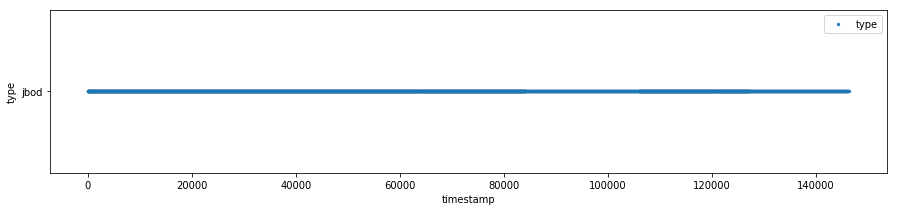

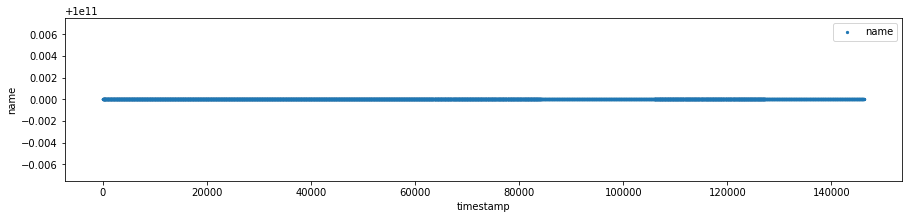

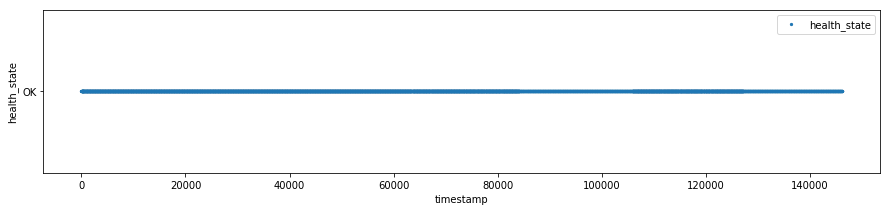

In [19]:
name = '100000000000'
plot_time_series(data[name], 'timestamp', data[name].columns)

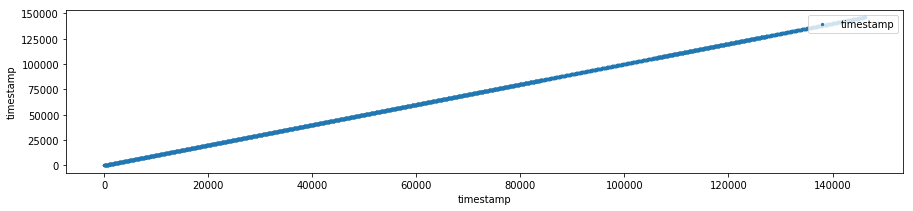

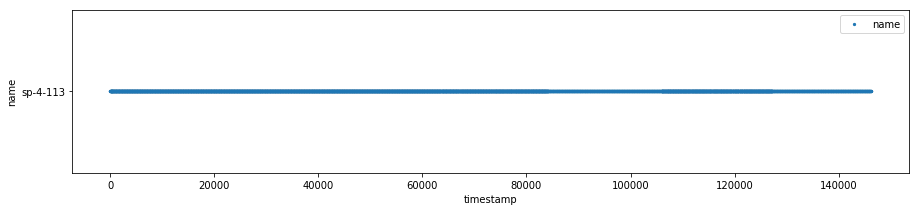

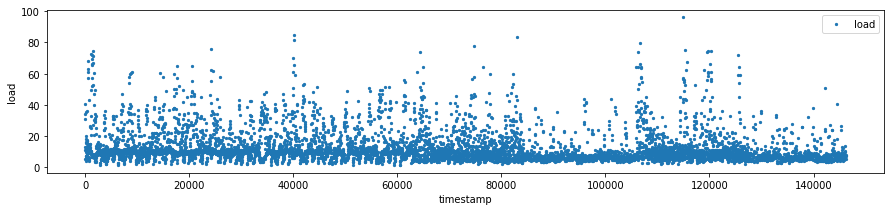

In [20]:
name = 'sp-4-113'
plot_time_series(data[name], 'timestamp', data[name].columns)

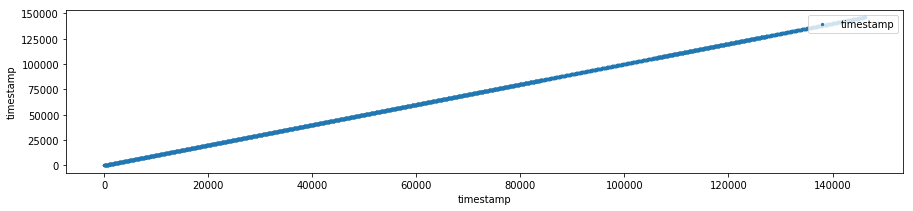

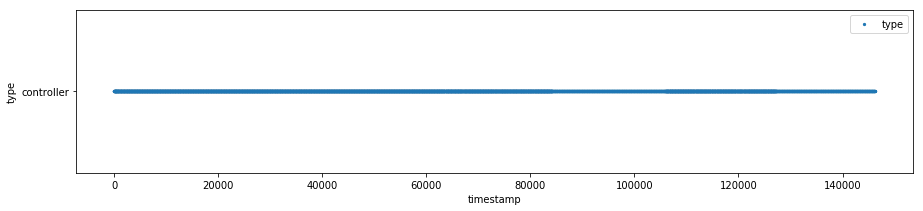

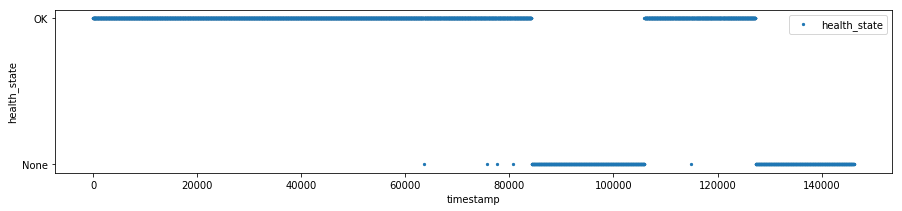

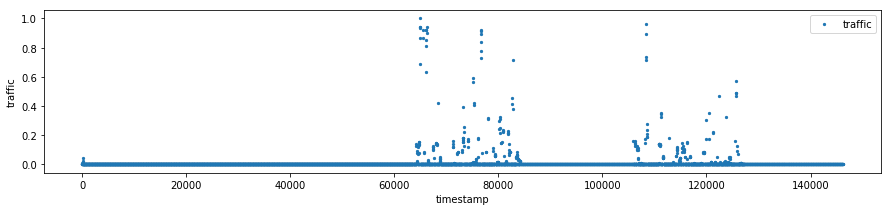

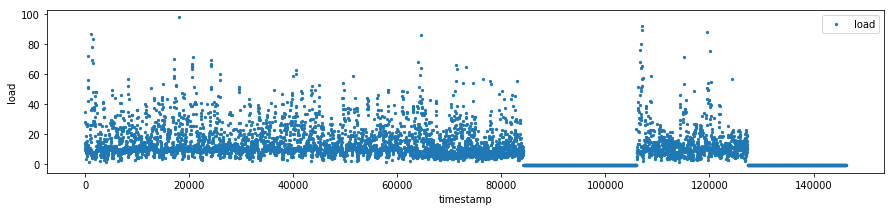

In [21]:
name = 'sp-235-199'
plot_time_series(data[name], 'timestamp', data[name].columns)

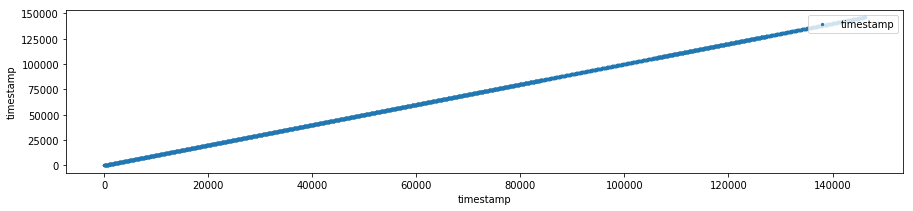

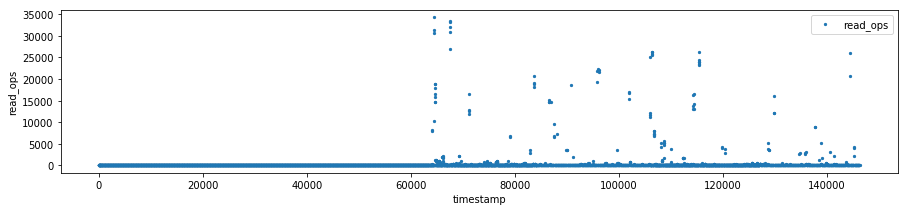

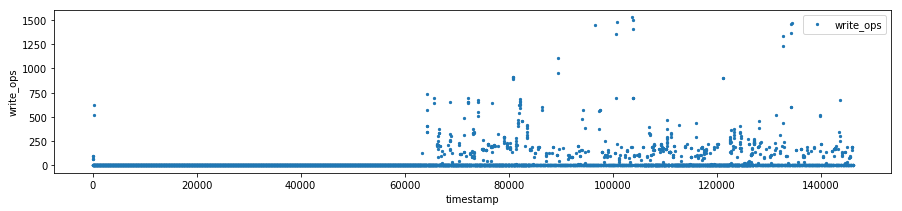

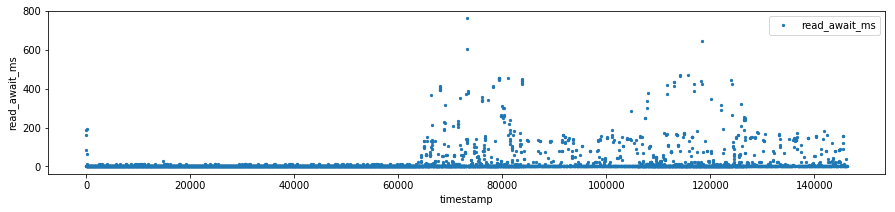

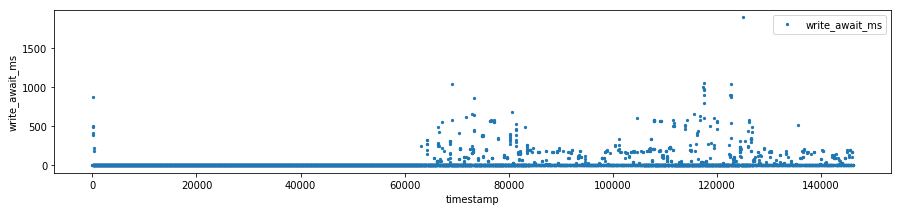

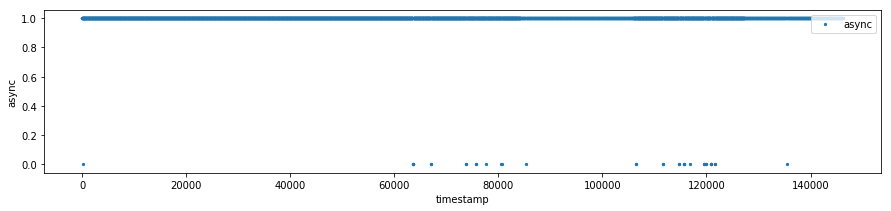

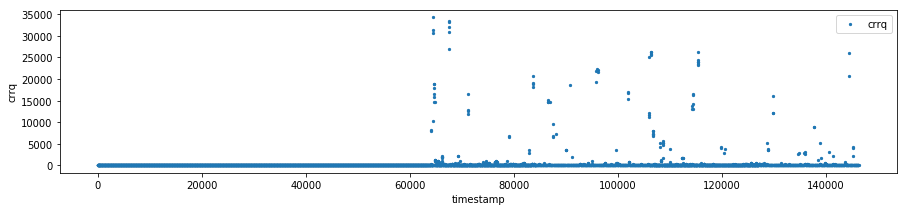

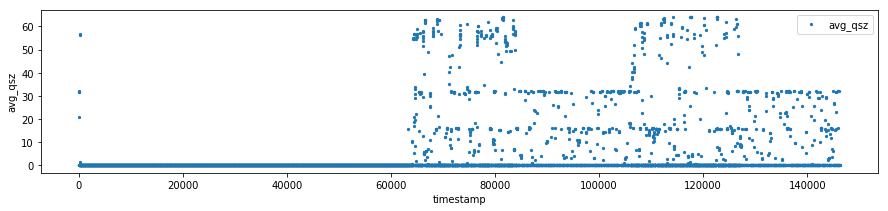

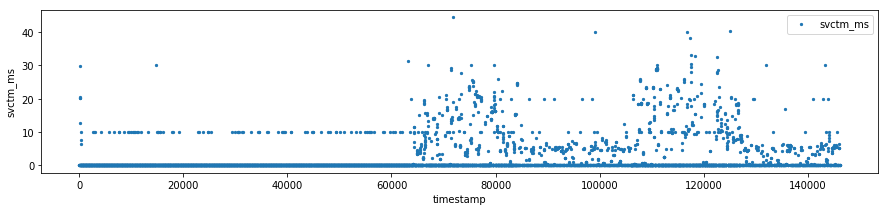

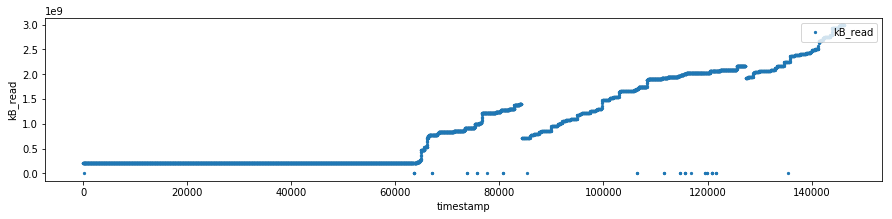

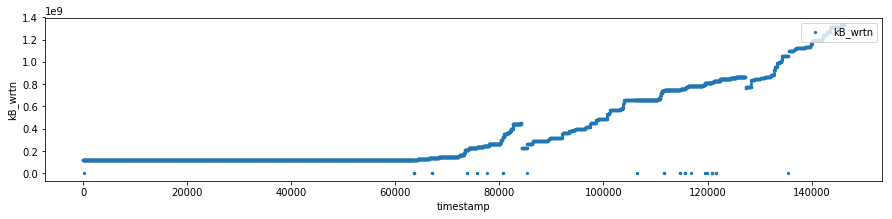

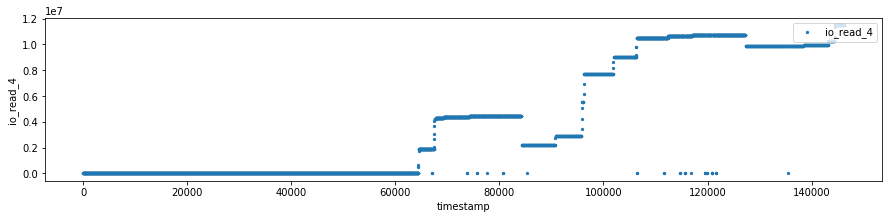

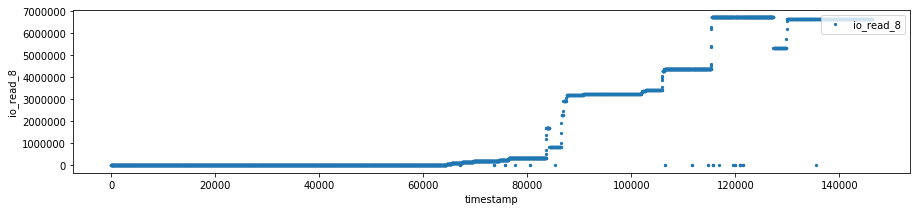

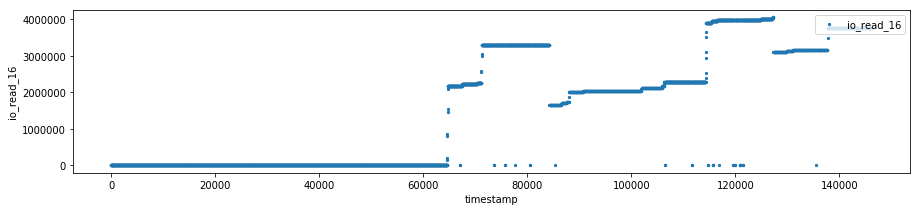

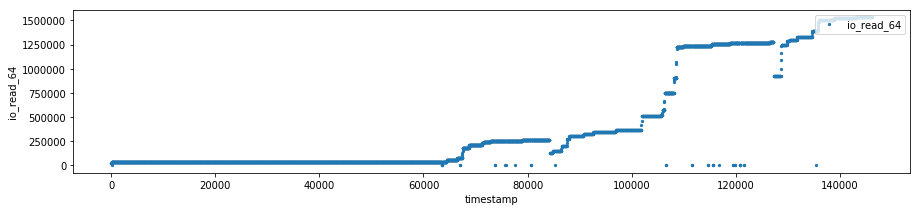

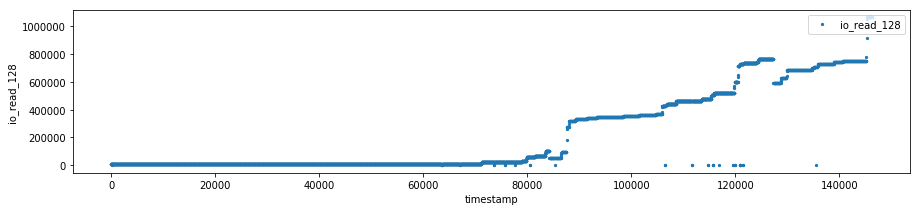

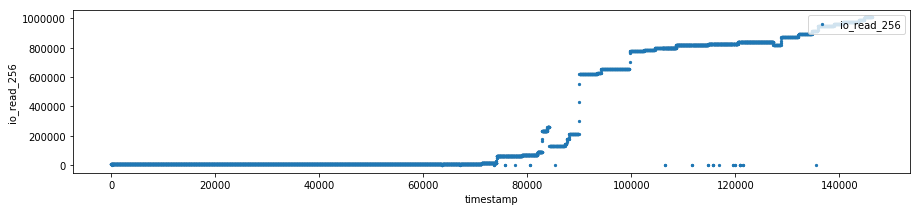

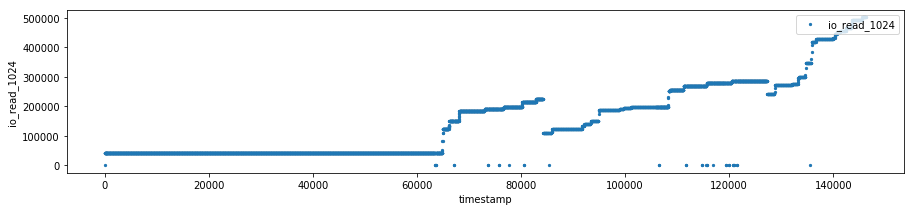

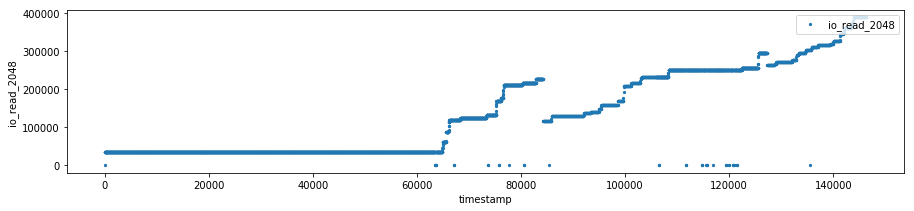

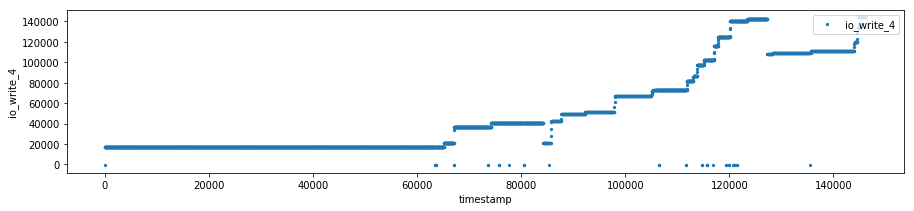

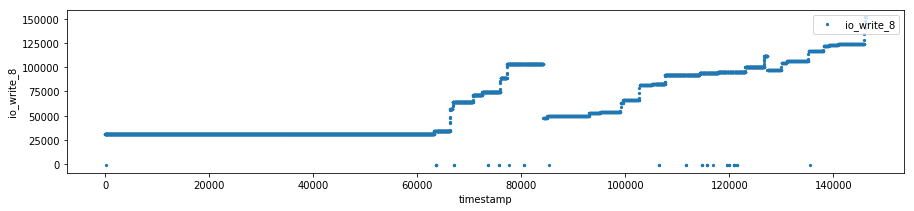

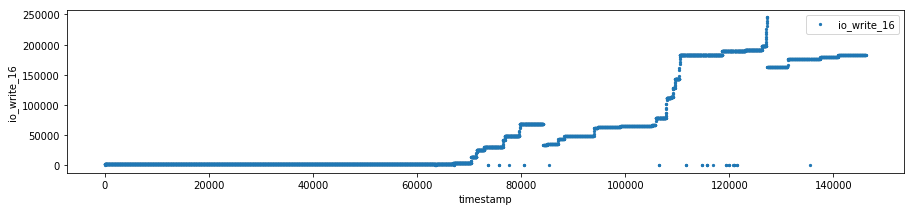

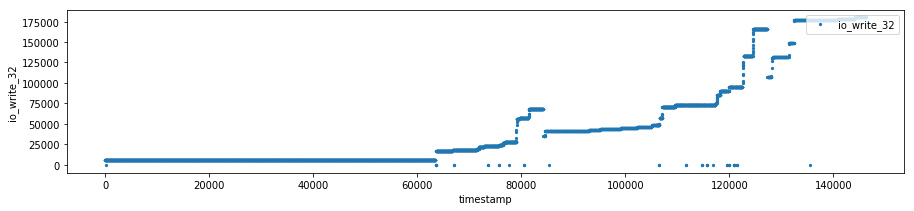

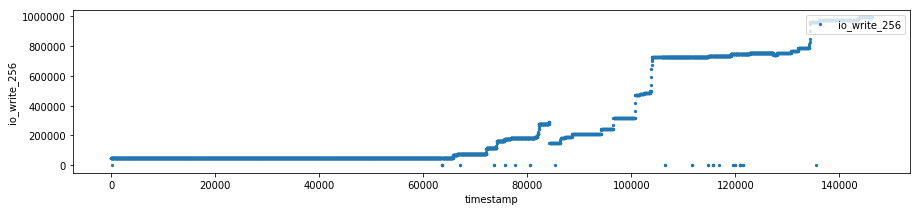

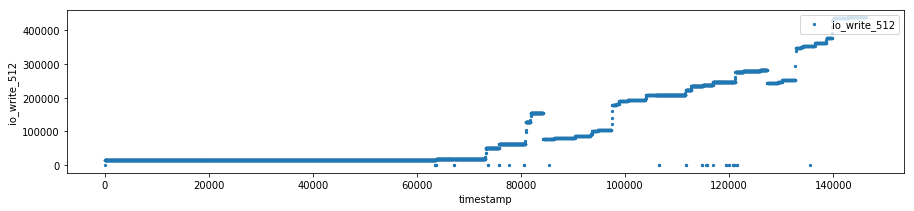

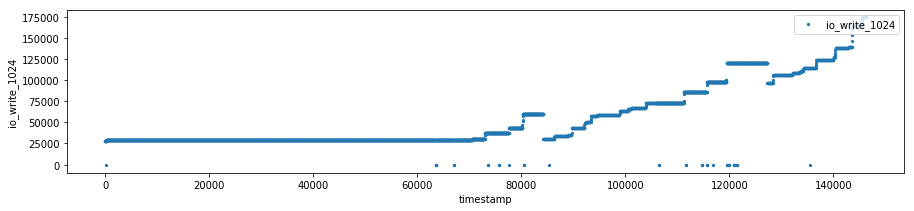

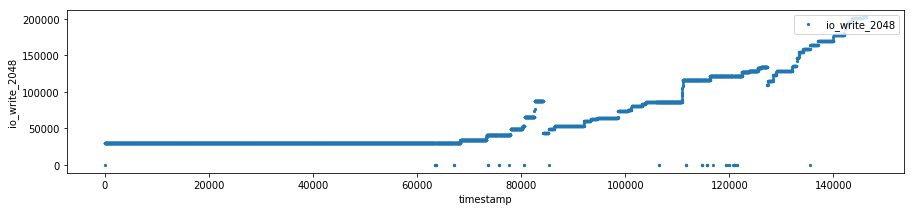

In [22]:
name = 'storage_state'
plot_time_series(data[name], 'timestamp', data[name].columns)

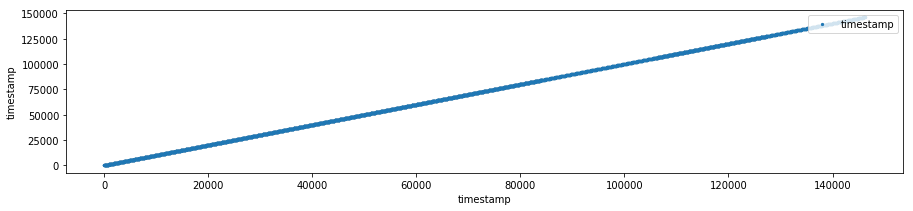

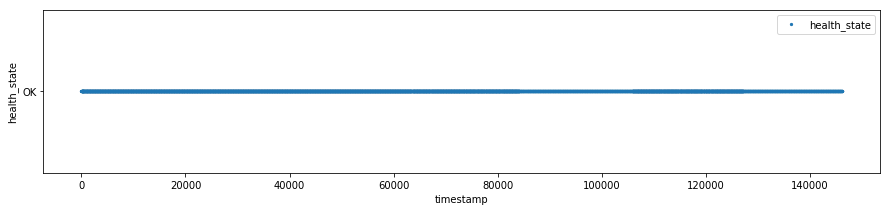

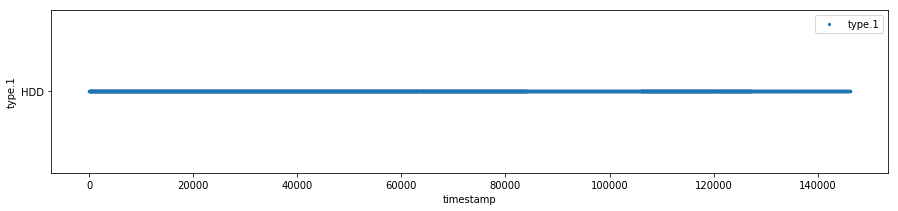

In [23]:
name = 'scsi-35000cca03e9852b8'
plot_time_series(data[name], 'timestamp', data[name].columns)

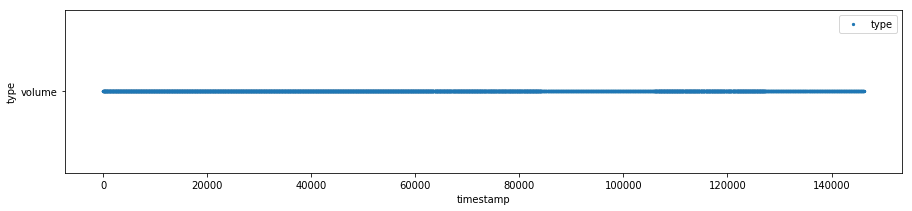

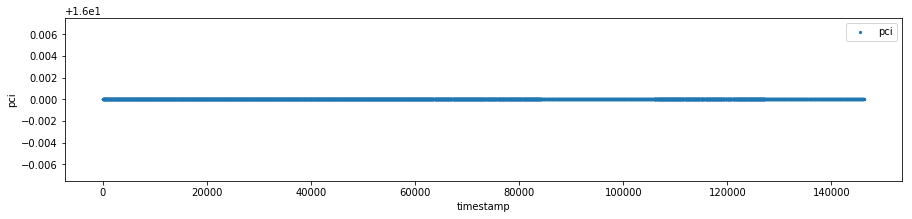

In [24]:
name = 'volume_679e1559-e395-4bcd-9f70-491c126acbcd_pty-vol-d236ddef-c1b0-11e8-8448-42054c31268b'
plot_time_series(data[name], 'timestamp', data[name].columns)

In [25]:
name = 'sp-235-199-rdma0'
plot_time_series(data[name], 'timestamp', data[name].columns)

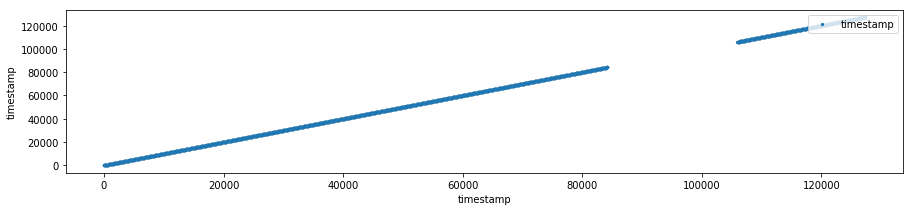

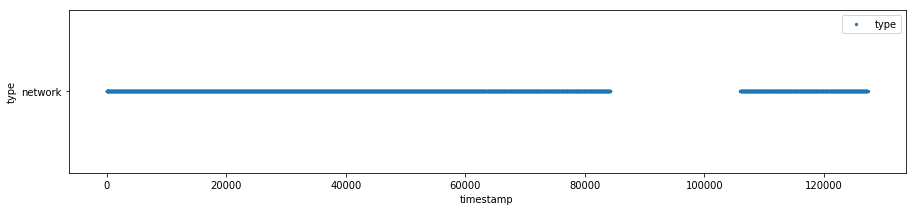

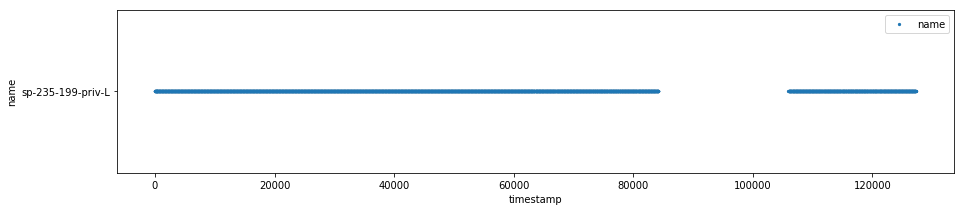

In [26]:
name = 'sp-235-199-priv-L'
plot_time_series(data[name], 'timestamp', data[name].columns)

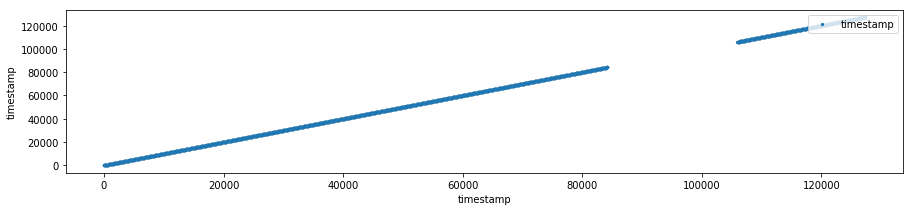

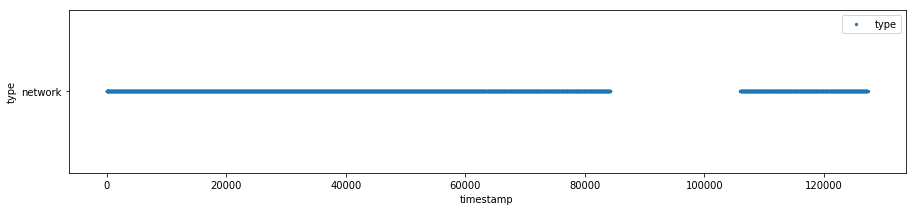

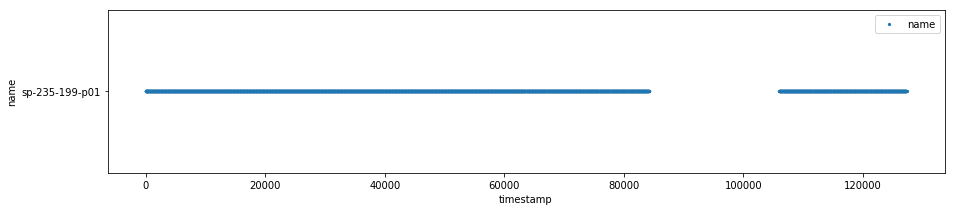

In [27]:
name = 'sp-235-199-p01'
plot_time_series(data[name], 'timestamp', data[name].columns)

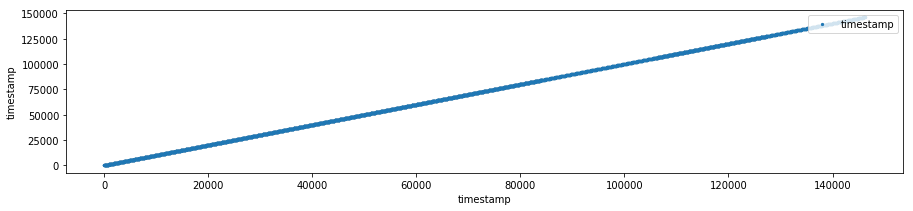

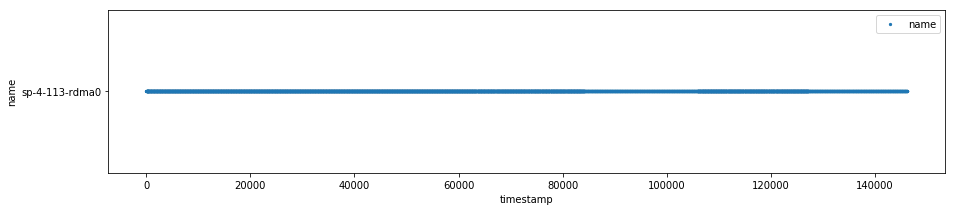

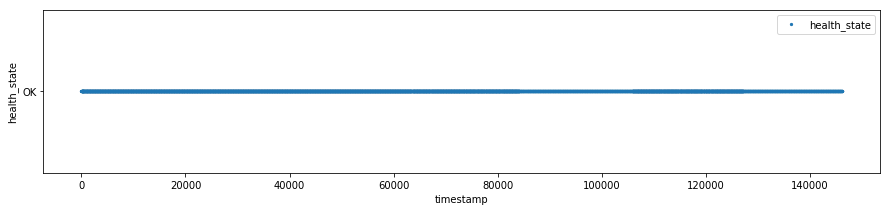

In [28]:
name = 'sp-4-113-rdma0'
plot_time_series(data[name], 'timestamp', data[name].columns)

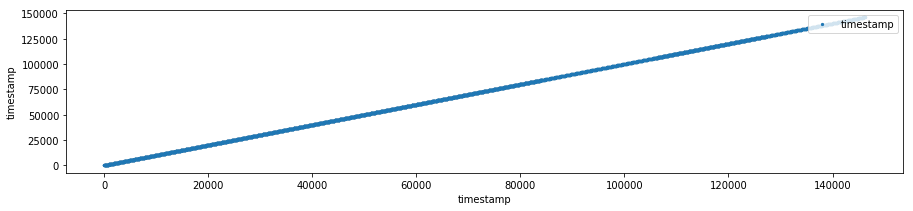

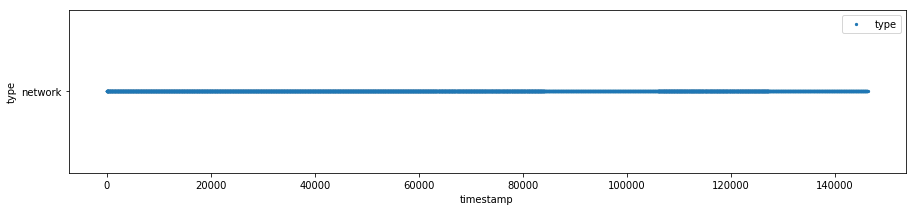

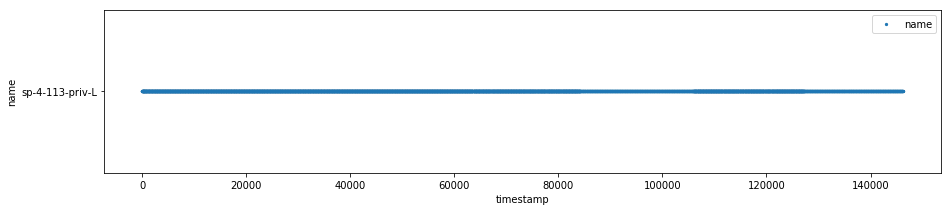

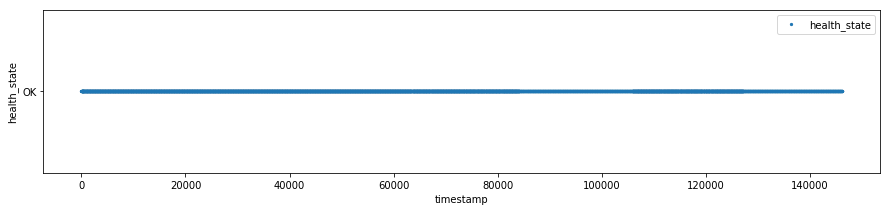

In [29]:
name = 'sp-4-113-priv-L'
plot_time_series(data[name], 'timestamp', data[name].columns)

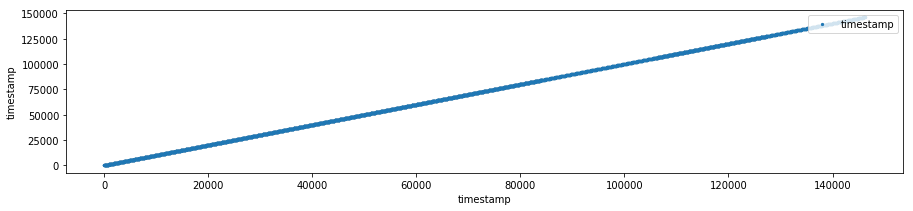

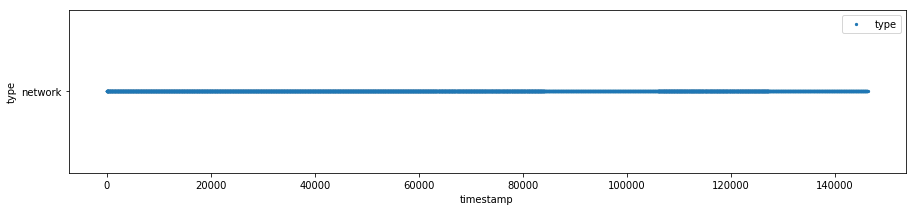

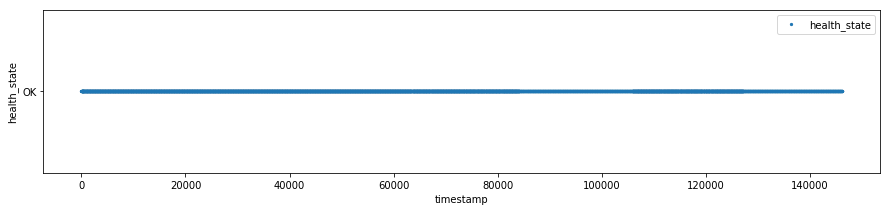

In [30]:
name = 'sp-4-113-p01'
plot_time_series(data[name], 'timestamp', data[name].columns)

# Train / Test data split

In [31]:
data.keys()

dict_keys(['100000000000', '100000000100', '100000000200', '100000000300', '100000000400', 'fc', 'scsi-35000cca03e900860', 'scsi-35000cca03e925b94', 'scsi-35000cca03e938d00', 'scsi-35000cca03e94a4f0', 'scsi-35000cca03e94a5d0', 'scsi-35000cca03e94a5d8', 'scsi-35000cca03e94ae60', 'scsi-35000cca03e94af5c', 'scsi-35000cca03e959ef4', 'scsi-35000cca03e95bb54', 'scsi-35000cca03e96692c', 'scsi-35000cca03e966940', 'scsi-35000cca03e966aec', 'scsi-35000cca03e966c48', 'scsi-35000cca03e96c6e0', 'scsi-35000cca03e973164', 'scsi-35000cca03e973350', 'scsi-35000cca03e975c28', 'scsi-35000cca03e975c30', 'scsi-35000cca03e975ff4', 'scsi-35000cca03e977678', 'scsi-35000cca03e9776e0', 'scsi-35000cca03e9776fc', 'scsi-35000cca03e977730', 'scsi-35000cca03e978228', 'scsi-35000cca03e981a20', 'scsi-35000cca03e982594', 'scsi-35000cca03e983a18', 'scsi-35000cca03e983abc', 'scsi-35000cca03e983d24', 'scsi-35000cca03e985284', 'scsi-35000cca03e9852b8', 'scsi-35000cca03e98551c', 'scsi-35000cca03e98565c', 'scsi-35000cca03e98

In [32]:
time_thresh = 100000

data_train = {}
data_test = {}

for companent_name in data.keys():
    
    if companent_name not in ['sp-235-199', 'sp-4-113']:
        continue
    
    data_component = data[companent_name]
    data_component_train = data_component[data_component['timestamp'] < time_thresh]
    data_component_test = data_component[data_component['timestamp'] >= time_thresh]
    
    data_train[companent_name] = data_component_train
    data_test[companent_name] = data_component_test

# Prediction and diagnostic analysis

## General pipeline definition

In [33]:
from nostradamus.instruments import CrystalBall, FortuneWheel
import sklearn


def analysis_pipeline(component_name='sp-235-199', signal_state='None', 
                      window_size=100, slice_size=10, prediction_horizont=0, method='RandomForest'):

    # Hide DeprecationWarning
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)

    # Select a component data
    data_train_component = {component_name: data_train[component_name]}
    data_test_component = {component_name: data_test[component_name]}

    # Train nostradamus
    model_train = FortuneWheel(window_size=window_size, 
                               slice_size=slice_size, 
                               prediction_horizont=prediction_horizont, 
                               method=method, 
                               timestamp_column='timestamp', 
                               state_column='health_state')
    model_train.fit(data_train_component)
    model_train.save_model('model.pkl')

    # Use trained nostradamus for predictions
    model_pred = CrystalBall()
    model_pred.load_models('model.pkl')
    output = model_pred.predict(data_test_component)
    
    # Time shift
    output[component_name]['timestamp'] += prediction_horizont * window_size

    # Merge truth and predictions
    # predictions = output[component_name].merge(data_test_component[component_name], on='timestamp', how='inner')
    predictions = pd.merge_asof(output[component_name], data_test_component[component_name], on='timestamp', direction='nearest')

    # Get true and predicted labels and sample weights for balanced metrics
    y_pred = predictions[signal_state].values
    y_test = (predictions['health_state'].values == signal_state) * 1.
    weights = np.ones(len(y_test)) * (y_test == 0) + 1. * (y_test == 1) * ((y_test == 0).sum()) / ((y_test == 1).sum())
    print("Number of test points after the preprocessing: ", len(y_test))
    
    # Calculate metric values
    log_loss = sklearn.metrics.log_loss(y_test, y_pred)
    auc = sklearn.metrics.roc_auc_score(y_test, y_pred)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred >= 0.5, sample_weight=weights)
    precision = sklearn.metrics.precision_score(y_test, y_pred >= 0.5, sample_weight=weights)
    recall = sklearn.metrics.recall_score(y_test, y_pred >= 0.5, sample_weight=weights)
    f1 = sklearn.metrics.f1_score(y_test, y_pred >= 0.5, sample_weight=weights)
    
    return (predictions, log_loss, auc, accuracy, precision, recall, f1)

Using Theano backend.


In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=100, 
                                                                                slice_size=10, 
                                                                                prediction_horizont=100, 
                                                                                method=clf)

log_loss, auc, accuracy, precision, recall, f1

Number of test points after the preprocessing:  454


(4.140947318756222,
 0.6935361457213333,
 0.6847553391099024,
 0.6617090768180396,
 0.7560137457044672,
 0.705724912915986)

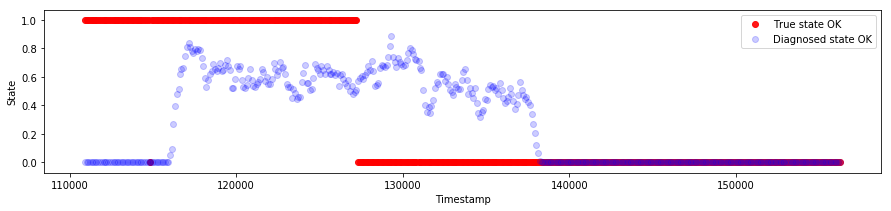

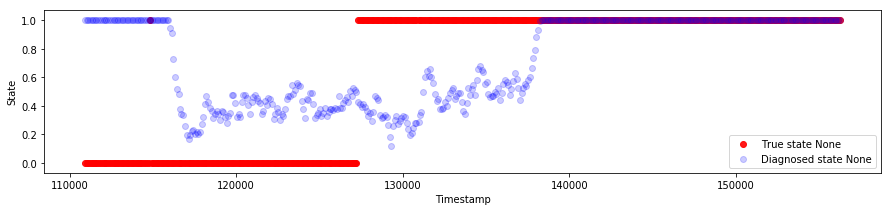

In [35]:
for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.2)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()

## Window size dependency analysis

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

metrics_columns = ['window_size', 'log_loss', 'auc', 'accuracy', 'precision', 'recall', 'f1']
metrics_data = []

window_sizes = np.arange(10, 310, 10)

for ws in window_sizes:
    
    print("Value %.2f is analysed..." % (ws))
    
    _, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                          signal_state='None', 
                                                                          window_size=ws, 
                                                                          slice_size=10, 
                                                                          prediction_horizont=0, 
                                                                          method=clf)
    
    metrics_data.append([ws, log_loss, auc, accuracy, precision, recall, f1])
    
metrics = pd.DataFrame(data=metrics_data, columns=metrics_columns)

Value 10.00 is analysed...
Number of test points after the preprocessing:  4615
Value 20.00 is analysed...
Number of test points after the preprocessing:  2303
Value 30.00 is analysed...
Number of test points after the preprocessing:  1533
Value 40.00 is analysed...
Number of test points after the preprocessing:  1147
Value 50.00 is analysed...
Number of test points after the preprocessing:  916
Value 60.00 is analysed...
Number of test points after the preprocessing:  762
Value 70.00 is analysed...
Number of test points after the preprocessing:  652
Value 80.00 is analysed...
Number of test points after the preprocessing:  569
Value 90.00 is analysed...
Number of test points after the preprocessing:  505
Value 100.00 is analysed...
Number of test points after the preprocessing:  454
Value 110.00 is analysed...
Number of test points after the preprocessing:  412
Value 120.00 is analysed...
Number of test points after the preprocessing:  377
Value 130.00 is analysed...
Number of test po

In [37]:
plt.figure(figsize=(11, 6))
plt.plot(metrics['window_size'].values, metrics['auc'].values, label='auc', linewidth=3)
plt.plot(metrics['window_size'].values, metrics['accuracy'].values, label='accuracy', linewidth=3)
plt.plot(metrics['window_size'].values, metrics['precision'].values, label='precision', linewidth=3)
plt.plot(metrics['window_size'].values, metrics['recall'].values, label='recall', linewidth=3)
plt.plot(metrics['window_size'].values, metrics['f1'].values, label='f1', linewidth=3)
plt.xlabel('window_size, s', size=14)
plt.ylabel('Metric value', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Number of test points after the preprocessing:  1533
Log_loss:  2.7738820618556015
auc:  0.8972883473379769
accuracy:  0.9197088973696371
precision:  0.9983277218206903
recall:  0.8408262454434995
f1:  0.9128329275327854


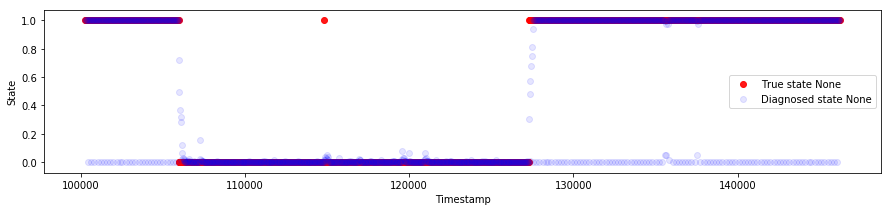

None   OK  Unknown      timestamp        type        name health_state  \
0   1.0  0.0      0.0  100256.106198  controller  sp-235-199         None   
1   1.0  0.0      0.0  100291.670192  controller  sp-235-199         None   
2   1.0  0.0      0.0  100327.409909  controller  sp-235-199         None   
3   1.0  0.0      0.0  100362.669229  controller  sp-235-199         None   
4   1.0  0.0      0.0  100398.298392  controller  sp-235-199         None   

   traffic  load  
0      0.0  -1.0  
1      0.0  -1.0  
2      0.0  -1.0  
3      0.0  -1.0  
4      0.0  -1.0

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=30, 
                                                                                slice_size=10, 
                                                                                prediction_horizont=0, 
                                                                                method=clf)

print("Log_loss: ", log_loss)
print("auc: ", auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.1)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()
    
predictions.head(5)

## Slice size dependency analysis

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

metrics_columns = ['slice_size', 'log_loss', 'auc', 'accuracy', 'precision', 'recall', 'f1']
metrics_data = []

slice_size = np.arange(1, 52, 2)

for ss in slice_size:
    
    print("Value %.2f is analysed..." % (ss))
    
    _, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                          signal_state='None', 
                                                                          window_size=100, 
                                                                          slice_size=ss, 
                                                                          prediction_horizont=0, 
                                                                          method=clf)
    
    metrics_data.append([ss, log_loss, auc, accuracy, precision, recall, f1])
    
metrics = pd.DataFrame(data=metrics_data, columns=metrics_columns)

Value 1.00 is analysed...
Number of test points after the preprocessing:  463
Value 3.00 is analysed...
Number of test points after the preprocessing:  461
Value 5.00 is analysed...
Number of test points after the preprocessing:  459
Value 7.00 is analysed...
Number of test points after the preprocessing:  457
Value 9.00 is analysed...
Number of test points after the preprocessing:  455
Value 11.00 is analysed...
Number of test points after the preprocessing:  453
Value 13.00 is analysed...
Number of test points after the preprocessing:  451
Value 15.00 is analysed...
Number of test points after the preprocessing:  449
Value 17.00 is analysed...
Number of test points after the preprocessing:  447
Value 19.00 is analysed...
Number of test points after the preprocessing:  445
Value 21.00 is analysed...
Number of test points after the preprocessing:  443
Value 23.00 is analysed...
Number of test points after the preprocessing:  441
Value 25.00 is analysed...
Number of test points after th

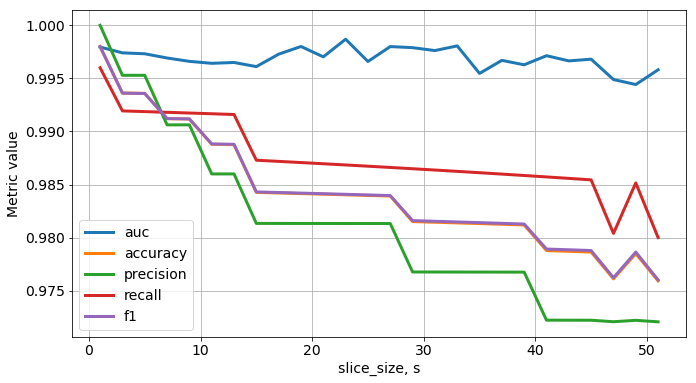

In [40]:
plt.figure(figsize=(11, 6))
plt.plot(metrics['slice_size'].values, metrics['auc'].values, label='auc', linewidth=3)
plt.plot(metrics['slice_size'].values, metrics['accuracy'].values, label='accuracy', linewidth=3)
plt.plot(metrics['slice_size'].values, metrics['precision'].values, label='precision', linewidth=3)
plt.plot(metrics['slice_size'].values, metrics['recall'].values, label='recall', linewidth=3)
plt.plot(metrics['slice_size'].values, metrics['f1'].values, label='f1', linewidth=3)
plt.xlabel('slice_size, s', size=14)
plt.ylabel('Metric value', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Number of test points after the preprocessing:  414
Log_loss:  0.0576865711912496
auc:  0.9970452899820148
accuracy:  0.9784528063905823
precision:  0.9721991701244814
recall:  0.9850746268656717
f1:  0.97859454944137


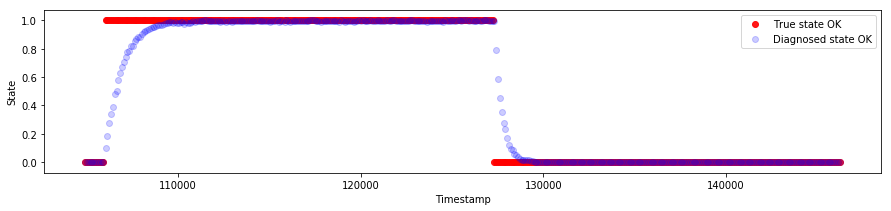

None   OK      timestamp        type        name health_state  traffic  \
0   1.0  0.0  104916.165400  controller  sp-235-199         None      0.0   
1   1.0  0.0  105022.941372  controller  sp-235-199         None      0.0   
2   1.0  0.0  105129.235161  controller  sp-235-199         None      0.0   
3   1.0  0.0  105236.061371  controller  sp-235-199         None      0.0   
4   1.0  0.0  105306.753365  controller  sp-235-199         None      0.0   

   load  
0  -1.0  
1  -1.0  
2  -1.0  
3  -1.0  
4  -1.0

In [41]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=100, 
                                                                                slice_size=50, 
                                                                                prediction_horizont=0, 
                                                                                method=clf)

print("Log_loss: ", log_loss)
print("auc: ", auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.2)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()
    
predictions.head(5)

## Prediction horisont dependency analysis

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

metrics_columns = ['prediction_horizont', 'log_loss', 'auc', 'accuracy', 'precision', 'recall', 'f1']
metrics_data = []

prediction_horizont = np.arange(0, 110, 10)

for pr in prediction_horizont:
    
    print("Value %.2f is analysed..." % (pr))
    
    _, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                          signal_state='None', 
                                                                          window_size=100, 
                                                                          slice_size=10, 
                                                                          prediction_horizont=pr, 
                                                                          method=clf)
    
    metrics_data.append([pr, log_loss, auc, accuracy, precision, recall, f1])
    
metrics = pd.DataFrame(data=metrics_data, columns=metrics_columns)

Value 0.00 is analysed...
Number of test points after the preprocessing:  454
Value 10.00 is analysed...
Number of test points after the preprocessing:  454
Value 20.00 is analysed...
Number of test points after the preprocessing:  454
Value 30.00 is analysed...
Number of test points after the preprocessing:  454
Value 40.00 is analysed...
Number of test points after the preprocessing:  454
Value 50.00 is analysed...
Number of test points after the preprocessing:  454
Value 60.00 is analysed...
Number of test points after the preprocessing:  454
Value 70.00 is analysed...
Number of test points after the preprocessing:  454
Value 80.00 is analysed...
Number of test points after the preprocessing:  454
Value 90.00 is analysed...
Number of test points after the preprocessing:  454
Value 100.00 is analysed...
Number of test points after the preprocessing:  454


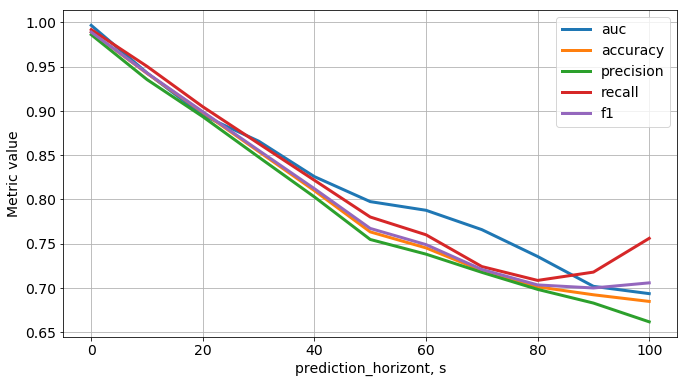

In [43]:
plt.figure(figsize=(11, 6))
plt.plot(metrics['prediction_horizont'].values, metrics['auc'].values, label='auc', linewidth=3)
plt.plot(metrics['prediction_horizont'].values, metrics['accuracy'].values, label='accuracy', linewidth=3)
plt.plot(metrics['prediction_horizont'].values, metrics['precision'].values, label='precision', linewidth=3)
plt.plot(metrics['prediction_horizont'].values, metrics['recall'].values, label='recall', linewidth=3)
plt.plot(metrics['prediction_horizont'].values, metrics['f1'].values, label='f1', linewidth=3)
plt.xlabel('prediction_horizont, s', size=14)
plt.ylabel('Metric value', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Number of test points after the preprocessing:  454
Log_loss:  4.140947318756222
auc:  0.6935361457213333
accuracy:  0.6847553391099024
precision:  0.6617090768180396
recall:  0.7560137457044672
f1:  0.705724912915986


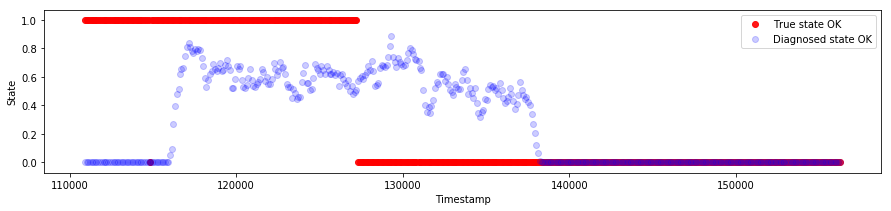

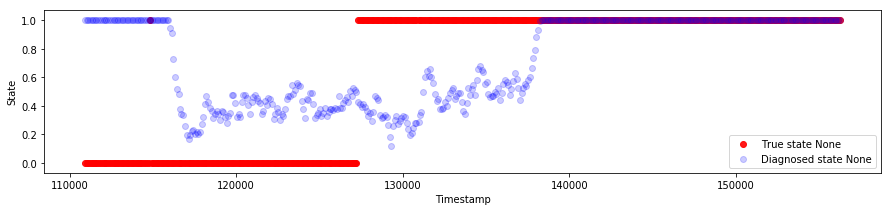

None   OK      timestamp        type        name health_state   traffic  \
0   1.0  0.0  110930.382718  controller  sp-235-199           OK  0.136703   
1   1.0  0.0  111037.068788  controller  sp-235-199           OK  0.133558   
2   1.0  0.0  111107.632864  controller  sp-235-199           OK  0.000000   
3   1.0  0.0  111214.480970  controller  sp-235-199           OK  0.343111   
4   1.0  0.0  111322.618028  controller  sp-235-199           OK  0.000000   

    load  
0   9.54  
1  22.43  
2   7.28  
3  22.26  
4   6.38

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=100, 
                                                                                slice_size=10, 
                                                                                prediction_horizont=100, 
                                                                                method=clf)

print("Log_loss: ", log_loss)
print("auc: ", auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.2)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()
    
predictions.head(5)

## Methods dependency analysis

### Original classifiers

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import keras
from nostradamus import classifiers


clf0 = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', 
                                 class_weight='balanced', n_jobs=-1, random_state=11)

clf1 = LogisticRegression()

clf2 = XGBClassifier(objective='binary:logistic', n_estimators=1000, max_depth=6, 
                     learning_rate=0.1, colsample_bytree=0.7)

clf3 = classifiers.KerasOneLayerNN(hidden_dim=100, nb_epoch=100, batch_size=32, patience=2)

clf4 = classifiers.KerasDeepNN(hidden_dim=100, n_hidden_layers=3, dropout=0.1, 
                               nb_epoch=100, batch_size=32, patience=2)

In [46]:
%%time

metrics_columns = ['model', 'log_loss', 'auc', 'accuracy', 'precision', 'recall', 'f1']
metrics_data = []

models = [clf0, clf1, clf2, clf3, clf4]

for i_model in range(len(models)):
    
    print("Value %.2f is analysed..." % (i_model))
    
    _, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                          signal_state='None', 
                                                                          window_size=100, 
                                                                          slice_size=10, 
                                                                          prediction_horizont=0, 
                                                                          method=models[i_model])
    
    metrics_data.append([i_model, log_loss, auc, accuracy, precision, recall, f1])
    
metrics = pd.DataFrame(data=metrics_data, columns=metrics_columns)

Value 0.00 is analysed...
Number of test points after the preprocessing:  454
Value 1.00 is analysed...
Number of test points after the preprocessing:  454
Value 2.00 is analysed...
Number of test points after the preprocessing:  454
Value 3.00 is analysed...
Number of test points after the preprocessing:  454
Value 4.00 is analysed...
Number of test points after the preprocessing:  454
CPU times: user 18.6 s, sys: 980 ms, total: 19.6 s
Wall time: 23 s


In [47]:
plt.figure(figsize=(11, 6))
plt.plot(metrics['model'].values, metrics['auc'].values, label='auc', linewidth=3)
plt.plot(metrics['model'].values, metrics['accuracy'].values, label='accuracy', linewidth=3)
plt.plot(metrics['model'].values, metrics['precision'].values, label='precision', linewidth=3)
plt.plot(metrics['model'].values, metrics['recall'].values, label='recall', linewidth=3)
plt.plot(metrics['model'].values, metrics['f1'].values, label='f1', linewidth=3)
plt.xlabel('model, s', size=14)
plt.ylabel('Metric value', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Number of test points after the preprocessing:  454
Log_loss:  0.018806727988735696
auc:  0.9993960999746752
accuracy:  0.9979253112033196
precision:  1.0
recall:  0.995850622406639
f1:  0.997920997920998


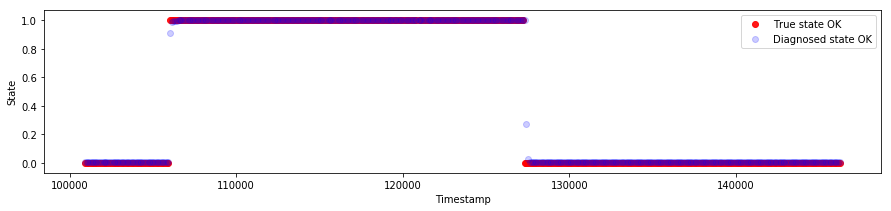

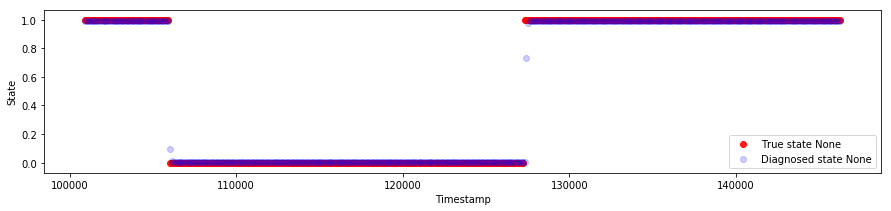

None        OK      timestamp        type        name health_state  \
0  0.994622  0.005378  100930.382718  controller  sp-235-199         None   
1  0.994622  0.005378  101037.068788  controller  sp-235-199         None   
2  0.994622  0.005378  101107.632864  controller  sp-235-199         None   
3  0.994622  0.005378  101214.480970  controller  sp-235-199         None   
4  0.994622  0.005378  101322.618028  controller  sp-235-199         None   

   traffic  load  
0      0.0  -1.0  
1      0.0  -1.0  
2      0.0  -1.0  
3      0.0  -1.0  
4      0.0  -1.0

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = XGBClassifier(objective='binary:logistic', n_estimators=1000, max_depth=6, 
                     learning_rate=0.1, colsample_bytree=0.7)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=100, 
                                                                                slice_size=10, 
                                                                                prediction_horizont=0, 
                                                                                method=clf)

print("Log_loss: ", log_loss)
print("auc: ", auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.2)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()
    
predictions.head(5)

### Jarvis classifiers

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import keras
from nostradamus import classifiers


config1 = {'RandomForest': {'estimator': RandomForestClassifier(n_estimators=1000), 
                            'params': {'max_depth': [3, 6, None], 
                                       'min_samples_leaf': [1, 10, 50], 
                                       'max_features': [None, 'auto', 0.8]}}}
clf1 = classifiers.JarvisClassifier(verbose=1)
clf1.set_config(config1)


config2 = {'LogisticRegresion': {'estimator': LogisticRegression(),
                                 'params': {'C': [5, 2, 1.5, 1, 0.5, 0.1, 0.01]}}}
clf2 = classifiers.JarvisClassifier(verbose=1)
clf2.set_config(config2)


config3 = {'XGBoost': {'estimator': XGBClassifier(objective='binary:logistic', n_estimators=1000),
                        'params': {'max_depth': [3, 4, 6, 8],
                                   'min_child_weight': [1, 10],
                                   'learning_rate': [0.1, 0.05, 0.01],
                                   'colsample_bytree': [0.7, 1]}}}
clf3 = classifiers.JarvisClassifier(verbose=1)
clf3.set_config(config3)


config4 = {'OneLayerNN': {'estimator': classifiers.KerasOneLayerNN(nb_epoch=100, batch_size=32, patience=2),
                          'params': {'hidden_dim': [10, 30, 100]}}}
clf4 = classifiers.JarvisClassifier(verbose=1)
clf4.set_config(config4)


config5 = {'DeepNN': {'estimator': classifiers.KerasDeepNN(nb_epoch=100, batch_size=32, patience=2),
                      'params': {'hidden_dim': [10, 30, 100],
                                 'n_hidden_layers': [2, 3, 4],
                                 'dropout': [0, 0.1, 0.3]}}}
clf5 = classifiers.JarvisClassifier(verbose=1)
clf5.set_config(config5)

In [50]:
%%time

metrics_columns = ['model', 'log_loss', 'auc', 'accuracy', 'precision', 'recall', 'f1']
metrics_data = []

models = [clf1, clf2, clf3, clf4, clf5]

for i_model in range(len(models)):
    
    print("Value %.2f is analysed..." % (i_model))
    
    _, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                          signal_state='None', 
                                                                          window_size=100, 
                                                                          slice_size=10, 
                                                                          prediction_horizont=0, 
                                                                          method=models[i_model])
    
    metrics_data.append([i_model, log_loss, auc, accuracy, precision, recall, f1])
    
metrics = pd.DataFrame(data=metrics_data, columns=metrics_columns)

Value 0.00 is analysed...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.1s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  1.5min finished


Number of test points after the preprocessing:  454
Value 1.00 is analysed...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=2)]: Done  21 out of  21 | elapsed:    0.1s finished


Number of test points after the preprocessing:  454
Value 2.00 is analysed...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 144 out of 144 | elapsed:   24.0s finished


Number of test points after the preprocessing:  454
Value 3.00 is analysed...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:   12.0s finished


Number of test points after the preprocessing:  454
Value 4.00 is analysed...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  4.9min finished


Number of test points after the preprocessing:  454
CPU times: user 14.8 s, sys: 456 ms, total: 15.3 s
Wall time: 7min 12s


In [51]:
plt.figure(figsize=(11, 6))
plt.plot(metrics['model'].values, metrics['auc'].values, label='auc', linewidth=3)
plt.plot(metrics['model'].values, metrics['accuracy'].values, label='accuracy', linewidth=3)
plt.plot(metrics['model'].values, metrics['precision'].values, label='precision', linewidth=3)
plt.plot(metrics['model'].values, metrics['recall'].values, label='recall', linewidth=3)
plt.plot(metrics['model'].values, metrics['f1'].values, label='f1', linewidth=3)
plt.xlabel('model, s', size=14)
plt.ylabel('Metric value', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 144 out of 144 | elapsed:   24.0s finished


Number of test points after the preprocessing:  454
Log_loss:  0.017141754113831086
auc:  0.9999220774160871
accuracy:  0.9979253112033196
precision:  1.0
recall:  0.995850622406639
f1:  0.997920997920998


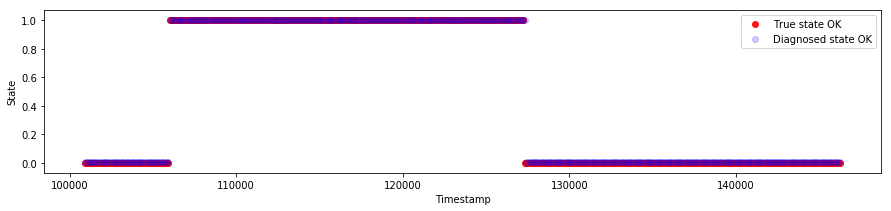

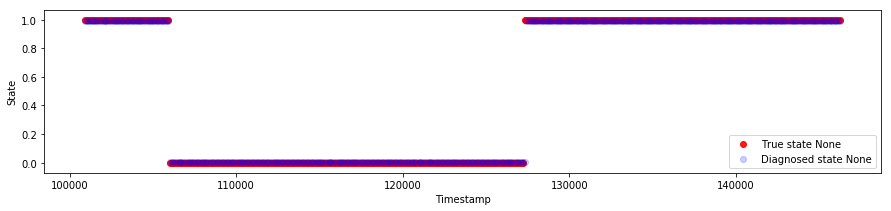

None        OK      timestamp        type        name health_state  \
0  0.994297  0.005703  100930.382718  controller  sp-235-199         None   
1  0.994297  0.005703  101037.068788  controller  sp-235-199         None   
2  0.994297  0.005703  101107.632864  controller  sp-235-199         None   
3  0.994297  0.005703  101214.480970  controller  sp-235-199         None   
4  0.994297  0.005703  101322.618028  controller  sp-235-199         None   

   traffic  load  
0      0.0  -1.0  
1      0.0  -1.0  
2      0.0  -1.0  
3      0.0  -1.0  
4      0.0  -1.0

In [52]:
from sklearn.ensemble import RandomForestClassifier

config3 = {'XGBoost': {'estimator': XGBClassifier(objective='binary:logistic', n_estimators=1000),
                        'params': {'max_depth': [3, 4, 6, 8],
                                   'min_child_weight': [1, 10],
                                   'learning_rate': [0.1, 0.05, 0.01],
                                   'colsample_bytree': [0.7, 1]}}}
clf3 = classifiers.JarvisClassifier(verbose=1)
clf3.set_config(config3)

predictions, log_loss, auc, accuracy, precision, recall, f1 = analysis_pipeline(component_name='sp-235-199', 
                                                                                signal_state='None', 
                                                                                window_size=100, 
                                                                                slice_size=10, 
                                                                                prediction_horizont=0, 
                                                                                method=clf3)

print("Log_loss: ", log_loss)
print("auc: ", auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

for state in ['OK', 'None']:
    plt.figure(figsize=(15, 3))
    plt.scatter(predictions['timestamp'].values, predictions['health_state'].values == state, label='True state '+str(state), color='r', alpha=0.9)
    plt.scatter(predictions['timestamp'].values, predictions[str(state)].values, label='Diagnosed state '+str(state), color='b', alpha=0.2)
    plt.legend(loc='best')
    plt.xlabel('Timestamp')
    plt.ylabel('State')
    plt.show()
    
predictions.head(5)